# SPEECH EMOTION CLASSIFICATION

In this notebook, we want to classify emotion in speech from audiofiles.

We use the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS). We only use the speech audio data, that consists of 1440 files. The database contains 24 professional actors (12 female, 12 male), vocalizing two lexically-matched statements in a neutral North American accent. Speech includes calm, happy, sad, angry, fearful, surprise, and disgust expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.

In [40]:
# import libraries
import os, glob
import numpy as np
import random
import librosa
import librosa.display
import matplotlib.pyplot as plt
import math
import shutil
import pandas as pd

In [41]:
# set main path
data_path = "your_path"

In [42]:
# list directories in main path
actor_fold = os.listdir(data_path)[1:]

In [43]:
# append all files
files = []
for actor in actor_fold:
    for file_path in glob.iglob(os.path.join(data_path,actor) + '/**/*.wav', recursive=True):
        files.append(os.path.basename(file_path))

In [44]:
# show file name structure
files[0]

'03-01-01-01-01-01-01.wav'

In [45]:
# create mapping dictionary
emotions = {'neutral':'01','calm':'02','happy':'03',
            'sad':'04','angry':'05','fearful':'06',
           'disgust':'07','surprised':'08'}

## listen to files and visualize them

To get a feeling what data we are dealing with we can listen to a couple of files:

In [46]:
# choose file
set_emo = 'angry' # neutral,calm,happy,sad,angry,fearful,disgust,surprised
set_actor = '19' # 1-24

In [47]:
# find sample
def sample(set_emo, set_actor):
    samples = []
    for i in range(len(files)):
        emo = files[i].split('-')[2]
        actor = files[i].split('-')[-1].split('.')[0]
        if emo == emotions[set_emo] and actor == set_actor:
            samples.append(files[i])
        
    return random.choice(samples)


In [48]:
# call function
s = sample(set_emo, set_actor)

In [49]:
# set full path
s_path = os.path.join(data_path, 'Actor_' + set_actor, s)

In [50]:
# play audiofile
import IPython.display as ipd
ipd.Audio(s_path)

Now let's have a look at what we are listening to. For this, we want to plot the amplitude of our signal over time (waveform):

In [51]:
# transform to waveform
def waveform(sample):
    x, sr = librosa.load(sample)
    return x, sr

In [52]:
# call function
x, sr = waveform(s_path)

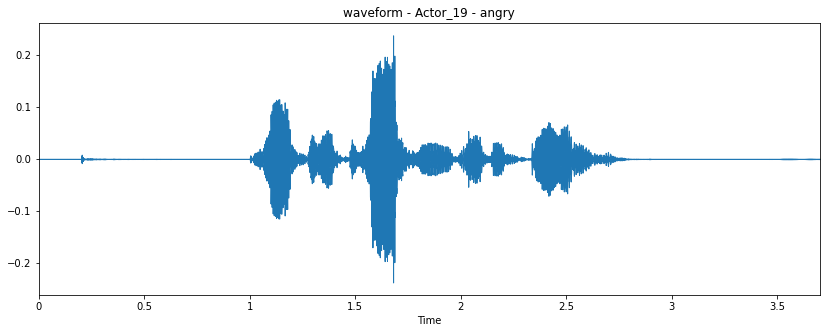

In [53]:
# plot waveform
plt.figure(figsize=(14, 5))
plt.title('waveform - ' + 'Actor_' + set_actor +' - '+ set_emo)
librosa.display.waveplot(x, sr=sr)

## using waveform statistics to train and predict

A reasonable first attempt we can try is to simply use the wavefile vector directly and extract statistics (min, max, mean, median and var) from it to create a data frame and train and predict on it. Usually, such an attempt is not sufficient to yield good classification. Nonetheless, we try and write a function to create the dataframe:

In [54]:
# create dataframe
def create_wave_dataframe(files, data_path):
    data = []
    labels = []
    for i in emotions:
        for j in range(len(files)):
            emo = files[j].split('-')[2]
            if emo == emotions[i]:
                actor = files[j].split('-')[-1].split('.')[0]
                file_path = os.path.join(data_path, 'Actor_' + actor, files[j])
                wave, sr = waveform(file_path)
                features = [np.mean(wave),np.min(wave),np.max(wave),np.median(wave),np.var(wave)]
                data.append(features)
                labels.append(int(emotions[i]))
        
    return data, labels

In [55]:
# call function
#data,labels = create_wave_dataframe(files, data_path) 

In [56]:
# convert list structure to numpy array
X = np.array(data)
y = np.array(labels)

In [58]:
# print dataframe shape
print(X.shape, y.shape)

((1440, 5), (1440,))

Our created dataframe contains 1440 samples and each sample is described by 5 statistics. 

First, we split our data into train and test set. Then we use an sklearn pipeline to standardize our data and then train with a boosting classifier in a 5-fold cross validation process:

In [59]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [60]:
# train Boosting classifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV,cross_val_score, KFold
import sklearn.metrics as metrics

pipeline = make_pipeline(StandardScaler(),HistGradientBoostingClassifier()) # StandardScaler(),
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
print('CV-score:', scores.mean(), 'std:', scores.std())

CV-score: 0.29166050933451554 std: 0.030250298464553016


Then, we predict on our test data:

In [61]:
# predict on test data
from sklearn.metrics import accuracy_score
pipeline = pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_test)
CA = accuracy_score(y_test, predictions)
print("classification accuracy:", CA)

classification accuracy: 0.28703703703703703


As expected, our first approach is classifying emotions rather poorly. Nevertheless, the accuracy is above chance level.

## using spectrogram statistics to train and predict

In mathematics, a Fourier transform (FT) is a mathematical transform that decomposes functions depending on space or time into functions depending on spatial or temporal frequency, such as the expression of a musical chord in terms of the volumes and frequencies of its constituent notes. The term Fourier transform refers to both the frequency domain representation and the mathematical operation that associates the frequency domain representation to a function of space or time.

in short, the Fourier transform decomposes a complex signal into its frequency components. Because humans sound perception normally ranges in the lower frequencies, either a log transform or a Mel transform (closer resembles human perception) can be applied. Another transformation is called the constant Q-transform (CQT). The CQT-based time-frequency analysis provides variable spectro-temporal resolution with higher resolution at lower frequencies. Since lower-frequency regions of speech signal contain more emotion-related information than higher-frequency regions, we use the CQT here.

Here, we calculate the five statistics for each column of the spectrogram to yield a better description of our data. But first, let's visualize how the transformed data looks like (the spectrograms):

In [62]:
# calculate Mel
def melspectrogram(x,sr):
    mel = librosa.feature.melspectrogram(x,sr=sr)
    mel_dB = librosa.power_to_db(mel, ref=np.max)
    return mel_dB

In [63]:
# calculate CQT
def constantQpower(x, sr):
    Q = np.abs(librosa.cqt(x, sr=sr))
    Q_dB = librosa.amplitude_to_db(Q, ref=np.max)
    return Q_dB

In [64]:
# call function
melspec = melspectrogram(x, sr)

In [65]:
# call function
Q = constantQpower(x, sr)

/Users/victor/opt/anaconda3/envs/ML/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/victor/opt/anaconda3/envs/ML/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


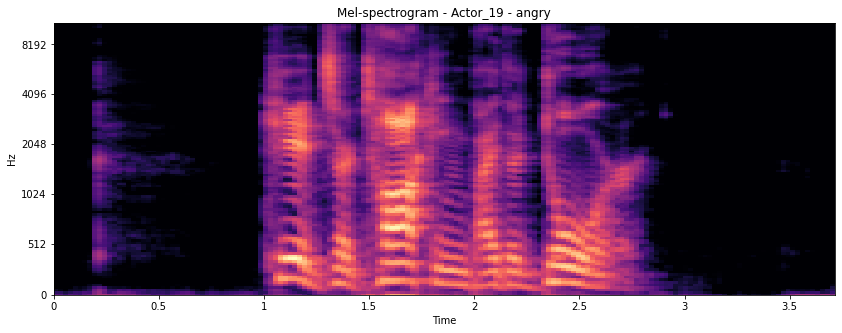

In [177]:
# plot Mel-spectrogram
plt.figure(figsize=(14, 5))
plt.title('Mel-spectrogram - ' + 'Actor_' + set_actor +' - '+ set_emo)
librosa.display.specshow(melspec, sr=sr, x_axis='time', y_axis='mel')

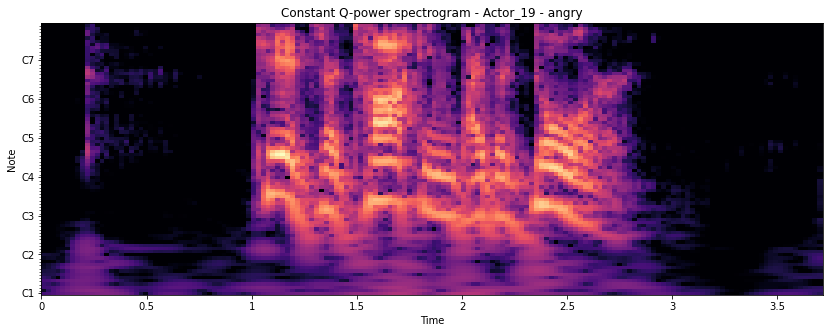

In [67]:
# plot CQT spectrogram
plt.figure(figsize=(14, 5))
plt.title('Constant Q-power spectrogram - ' + 'Actor_' + set_actor +' - '+ set_emo)
librosa.display.specshow(Q,sr=sr, x_axis='time', y_axis='cqt_note')

We can already appreciate that the lower frequencies in the Constant Q-power spectrogram are more resolved compared to the Mel-spectrogram.

And now we write a function to create the dataframe:

In [77]:
# create spectrogram dataframe
def create_spec_dataframe(files, data_path, transform):
    data = []
    labels = []
    for i in emotions:
        for j in range(len(files)):
            emo = files[j].split('-')[2]
            if emo == emotions[i]:
                actor = files[j].split('-')[-1].split('.')[0]
                file_path = os.path.join(data_path, 'Actor_' + actor, files[j])
                wave, sr = waveform(file_path)
                if transform == 'mel':
                    spec = melspectrogram(wave, sr)
                if transform == 'Q':
                    spec = constantQpower(wave, sr)
                    
                features = []
                for win in spec:
                    features.append(np.mean(win))
                    features.append(np.min(win))
                    features.append(np.max(win))
                    features.append(np.median(win))
                    features.append(np.var(win))
                    
                data.append(features)
                labels.append(int(emotions[i]))
                
        print('emotion ' + i + ' processed..')
    
    return data, labels

Set type of spectrogram:

In [78]:
# set spectrogram type
transform = 'Q' # or 'mel'

Create data frame:

In [79]:
# call function
#data_spec, labels_spec = create_spec_dataframe(files, data_path, transform)

emotion neutral processed..
emotion calm processed..
emotion happy processed..
emotion sad processed..
emotion angry processed..
emotion fearful processed..
emotion disgust processed..
emotion surprised processed..


In [80]:
# convert list structure to numpy array
X_spec = np.array(data_spec)
y_spec = np.array(labels_spec)

In [82]:
# print shape
print(X_spec.shape, y_spec.shape)

((1440, 420), (1440,))

Our created dataframe contains 1440 samples and each sample is described by 84*5 (420) statistics. 

Now we split our dataframe into train and test set:

In [83]:
# split data
X_train_spec, X_test_spec, y_train_spec, y_test_spec = train_test_split(X_spec, y_spec, test_size=0.3, random_state=42)

Then run the Boosting Classifier for 5 cross validation rounds:

In [84]:
# train Boosting classifier
pipeline = make_pipeline(StandardScaler(),HistGradientBoostingClassifier())
scores = cross_val_score(pipeline, X_train_spec, y_train_spec, cv=5, scoring='accuracy')
print('CV-score:', scores.mean(), 'std:', scores.std())

CV-score: 0.5138958671986601 std: 0.017828363760264785


And finally predict on unseen (test) data:

In [85]:
# predict on test data
pipeline = pipeline.fit(X_train_spec, y_train_spec)
predictions = pipeline.predict(X_test_spec)
CA = accuracy_score(y_test_spec, predictions)
print("classification accuracy:", CA)

classification accuracy: 0.5092592592592593


We can see that by using information from spectrograms we significantly improved our classification accuracy.

## using convolutional neural network to train and predict on spectrograms

Our final approach is to use a convolutional neural network (CNN) to train and predict on the spectrograms. This way, we do not lose any information (before, we strongly reduced the information by describing it via statistics). Because using CNNs is computationally heavy (especially on CPU), we save the images to a folder structure and make use of the generator function provided by keras.

In [86]:
# set path and create folder
save_path = "your_path"

if not os.path.isdir(save_path): 
    os.makedirs(save_path)

In [87]:
# create and save raw data into folder
def save_spectrograms(files, data_path, transform):
    for i in emotions:
        current_folder = os.path.join(save_path,i)
        if not os.path.isdir(current_folder): 
            os.makedirs(current_folder)
        cnt = 1
        for j in range(len(files)):
            emo = files[j].split('-')[2]
            if emo == emotions[i]:
                actor = files[j].split('-')[-1].split('.')[0]
                file_path = os.path.join(data_path, 'Actor_' + actor, files[j])
                wave, sr = waveform(file_path)
                if transform == 'mel':
                    melspec = melspectrogram(wave, sr)
                    plt.figure(figsize=(3, 3))
                    librosa.display.specshow(melspec, sr=sr)
                    plt.savefig(os.path.join(current_folder,'{0}_{1}.png'.format(i, cnt)) , bbox_inches='tight', pad_inches=0)
                    plt.close()
                if transform == 'Q':
                    Q = constantQpower(wave, sr)
                    plt.figure(figsize=(3, 3))
                    librosa.display.specshow(Q, sr=sr)
                    plt.savefig(os.path.join(current_folder,'{0}_{1}.png'.format(i, cnt)) , bbox_inches='tight', pad_inches=0)
                    plt.close()
                cnt += 1

        print('emotion ' + i + ' processed..')

In [88]:
# set spectrogram type
transform = 'Q'

In [181]:
# call function
#save_spectrograms(files, data_path, transform) # --> only run once!

In [90]:
# extract emotions
cl = []
for i in emotions:
    cl.append(i)

In [91]:
# set source and target paths
source_dir = "your_path"
target_dir = "your_path"

In [91]:
# iterate through raw data
def collect_candidates(folder_path):
    
    candidates = []
    
    for filename in glob.iglob(folder_path + '/**/*.png', recursive=True):
        candidates.append(filename)
    
    return candidates

In [92]:
# redesign names and copy files to new folder
def create_images(candidates, imgsave_path, file_prefix):
    
    cnt = 0
    for filename in candidates:
        cnt += 1
        new_filename = os.path.join(imgsave_path, '{0}_{1}.png'.format(file_prefix, cnt))
        shutil.copy(filename, new_filename)

In [93]:
# create data randomly and splitting into training, test and validation     
def process(dist_training, dist_test, dist_validation):

    classes = cl
    distributions = {'training': dist_training, 'test': dist_test, 'validation': dist_validation}
        
    for cls in classes:
        candidates = collect_candidates(os.path.join(source_dir, cls))
        random.shuffle(candidates)
        
        offset = 0
        for key, percentage in distributions.items(): 
            
            share = math.floor(len(candidates) / 100 * percentage)
            
            class_path = os.path.join(target_dir, key, cls)
            if not os.path.isdir(class_path): 
                os.makedirs(class_path)
            
            create_images(candidates[offset:offset+share], class_path, cls)
            offset += share

In [180]:
# call function
# choose percentages for: 'process(training,validation,testing)' 
#process(70,15,15) # --> only run once!

In [95]:
# import libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.metrics import balanced_accuracy_score
import tensorflow as tf
from PIL import Image

In [96]:
# set directory
train_data_dir = os.path.join(target_dir, 'training')
validation_data_dir = os.path.join(target_dir, 'validation')
test_data_dir = os.path.join(target_dir, 'test')

In [97]:
# extract number of training / validation samples
t = []
v = []
T = []
for t_file in glob.iglob(train_data_dir + '/**/*.png', recursive=True):
    t.append(t_file)
for v_file in glob.iglob(validation_data_dir + '/**/*.png', recursive=True):
    v.append(v_file)
for T_file in glob.iglob(test_data_dir + '/**/*.png', recursive=True):
    T.append(T_file)
t_l = len(t)
v_l = len(v)
T_l = len(T)

In [98]:
# extract weights
path = source_dir
classes = os.listdir(path)

cnt_list = []
for cl in classes:
    cnt = 0
    for i in glob.iglob(os.path.join(path,cl) + '/**/*.png', recursive=True):
        cnt += 1
    cnt_list.append(cnt)

w_list = []
total = sum(cnt_list)
for i in cnt_list:
    w_list.append((1 / i)*(total)/len(cnt_list)) 

weights = {}
for i in range(len(w_list)):
    weights[i] = w_list[i]

print('weight distribution among classes:',weights)

weight distribution among classes: {0: 0.9375, 1: 0.9375, 2: 0.9375, 3: 0.9375, 4: 0.9375, 5: 1.875, 6: 0.9375, 7: 0.9375}


In [99]:
# extract image size
im = Image.open(t[0])
img_width, img_height = im.size
print('our images are of size: ', img_height, img_width, '3')

our images are of size:  166 170 3


In [100]:
# set network parameter
epochs = 50
batch_size = 15
nclasses = len(classes)
loss_type = 'categorical_crossentropy' 
class_type = 'categorical' 
activation_fun = 'softmax' 
nb_train_samples = t_l*nclasses 
nb_validation_samples = v_l#*nclasses 
nb_test_samples = T_l
learning_rate = 0.00015
dropout_rate = 0.5
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=3, min_lr=0.000005)
early = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min')

In [101]:
# set input shape of images
input_shape = (img_height, img_width, 3)

In [102]:
# design the CNN

# conv layer 1
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# conv layer 2
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# conv layer 3
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# conv layer 4
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten layer
model.add(Flatten())

# dense layer 1
model.add(Dense(128))
model.add(Activation('relu'))

# dropout layer 1
model.add(Dropout(dropout_rate))

# dense layer 2
model.add(Dense(128))
model.add(Activation('relu'))

# dropout layer 2
model.add(Dropout(dropout_rate))

# output layer
model.add(Dense(nclasses))
model.add(Activation(activation_fun))

# set optimizer
opt = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# compile model
model.compile(loss=loss_type,
              optimizer=opt,
              metrics=['accuracy']) 

# merge callbacks
callbacks = [early, reduce_lr]

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 164, 168, 32)      896       
_________________________________________________________________
activation_7 (Activation)    (None, 164, 168, 32)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 82, 84, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 80, 82, 64)        18496     
_________________________________________________________________
activation_8 (Activation)    (None, 80, 82, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 40, 41, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 38, 39, 128)      

In [103]:
# plot a graph of the CNN
#plot_model(model, to_file='speech_emotion_net.png', show_shapes=True, show_layer_names=True)

In [104]:
# set train, validation and test data generators

train_datagen = ImageDataGenerator(rescale=1. / 255)
validation_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=class_type)

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=class_type)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=class_type,
    shuffle = False)

print(train_generator.class_indices)

Found 1005 images belonging to 8 classes.
Found 210 images belonging to 8 classes.
Found 210 images belonging to 8 classes.
{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [105]:
# train the CNN
history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    class_weight = weights,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
536/536 [==============================] - 311s 580ms/step - loss: 1.9966 - acc: 0.2030 - val_loss: 1.7876 - val_acc: 0.3619
Epoch 2/50
536/536 [==============================] - 308s 574ms/step - loss: 1.6522 - acc: 0.3840 - val_loss: 1.3327 - val_acc: 0.5286
Epoch 3/50
536/536 [==============================] - 317s 592ms/step - loss: 1.2205 - acc: 0.5412 - val_loss: 0.9979 - val_acc: 0.6286
Epoch 4/50
536/536 [==============================] - 331s 618ms/step - loss: 0.8625 - acc: 0.6816 - val_loss: 0.8409 - val_acc: 0.7000
Epoch 5/50
536/536 [==============================] - 307s 573ms/step - loss: 0.5819 - acc: 0.7811 - val_loss: 0.8855 - val_acc: 0.7381
Epoch 6/50
536/536 [==============================] - 366s 683ms/step - loss: 0.4558 - acc: 0.8333 - val_loss: 0.8092 - val_acc: 0.7762
Epoch 7/50
536/536 [==============================] - 341s 637ms/step - loss: 0.3270 - acc: 0.8762 - val_loss: 0.9341 - val_acc: 0.7381
Epoch 8/50
536/536 [============================

In [106]:
# save the model
#model.save(os.path.join(os.path.dirname(data_path),'speech_emotion_net') + '.h5')

In [229]:
# get early stopping epoch
val_loss_min = np.argmin(history.history['val_loss'])
loss_mean = np.mean(history.history['val_loss'])
acc_mean = np.mean(history.history['acc'])

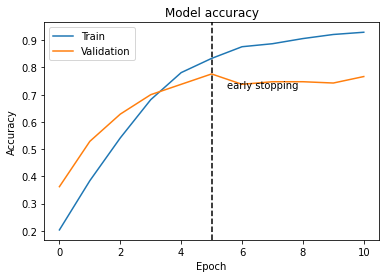

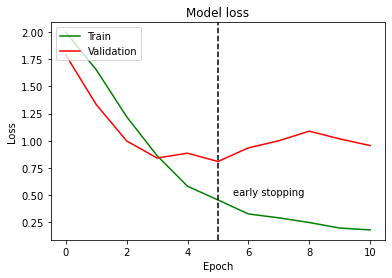

<Figure size 432x288 with 0 Axes>

In [230]:
# plot training and validation accuracy & loss values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.axvline(x=val_loss_min, color='black', linestyle='--')
plt.text(val_loss_min+0.5, acc_mean, 'early stopping', fontdict=None)
plt.show()
plt.savefig(os.path.join(os.path.dirname(data_path), 'accuracy_speech_emotion.png'))
#plt.close()

plt.plot(history.history['loss'], color='green')
plt.plot(history.history['val_loss'], color='red')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.axvline(x=val_loss_min, color='black', linestyle='--')
plt.text(val_loss_min+0.5, 0.5, 'early stopping', fontdict=None)
plt.show()
plt.savefig(os.path.join(os.path.dirname(data_path), 'loss_speech_emotion.png'))
#plt.close()

In [231]:
# predict on test set

# only if notebook is reloaded and model already saved:
#model = tf.keras.models.load_model('/Volumes/WD_My_Passport/emotion_data/speech_emotion_net.h5')

Y_pred = model.predict_generator(test_generator, nb_test_samples // batch_size)
y_pred = np.argmax(Y_pred, axis=1)

from sklearn.metrics import accuracy_score
CA = accuracy_score(validation_generator.classes, y_pred)
print('classification accuracy:', CA)

classification accuracy: 0.7571428571428571


With our final method we have improved the classification accuracy again quite a bit.

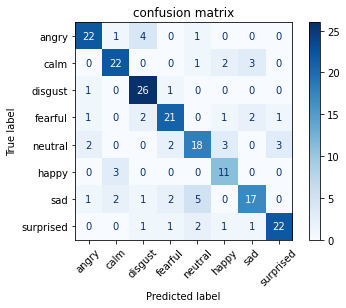

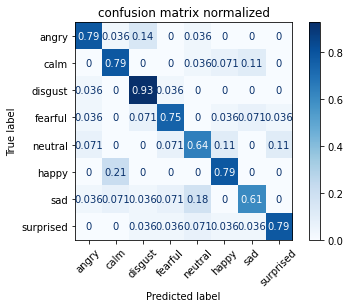

In [174]:
# calculate and plot confusion matrix
target_names = ['angry','calm','disgust','fearful','neutral','happy','sad','surprised']

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.title('confusion matrix')
plt.xticks(ticks=None, labels=None, rotation=45)
plt.show()

cm = confusion_matrix(test_generator.classes, y_pred,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

disp.plot(cmap=plt.cm.Blues)
plt.title('confusion matrix normalized')
plt.xticks(ticks=None, labels=None, rotation=45)
plt.show()

The confusion matrix reveals that the model had most difficulties with classifying the emotions 'neutral' and 'sad'. In contrast, the emotion 'disgust' was the easiest to classify. All other emotions were equally nicely classified.

## survey to assess human performance

Finally, we want to investigate how well humans perform in classifying the emotion dataframe. There were 20 subjects in the survey and each subject had to classify 28 sound samples. The accuracy was calculated as 'correct answers' divided by 'total samples'. We want to visualize our results with a density plot, where we insert the average of the human performance and the accuracy of our model.

In [190]:
# import survey data and create pandas dataframe
survey_path = "your_path"
df_survey = pd.read_excel(survey_path)

In [191]:
# extract human average and classification accuracy
avg = np.mean(df_survey['CA'])
ca = CA*100

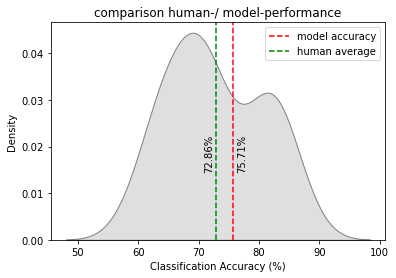

In [198]:
# plot all data
import seaborn as sns
df_dens = df_survey['CA']
sns.kdeplot(df_dens, color='grey',shade=True)
plt.axvline(x=ca, color='r', linestyle='--', label='model accuracy')
plt.axvline(x=avg, color='g', linestyle='--', label='human average')
plt.xlabel('Classification Accuracy (%)')
plt.text(avg-2, 0.015, str(round(avg,2))+'%', rotation=90, fontdict=None)
plt.text(ca+0.7, 0.015, str(round(ca,2))+'%', rotation=90, fontdict=None)
plt.title('comparison human-/ model-performance')
plt.legend()

We can see that our final classifier even outperforms human accuracy by 3% on this dataframe. 